In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import matplotlib.pyplot as plt
from dsa_analysis import Simulation, combine_simulations, visualize, load_config
import DSA
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS
import numpy as np
from itertools import permutations
import similarity


%load_ext autoreload
%autoreload 2

## Parameters

We simulate with $num\_samples$ possible initializations accross $num\_steps$ 

Parameters to compute the dissimilarity matrices and the Procrustes Alignment over Vector Fields, according to [1]

In [2]:
config = load_config('../config.yaml')

# Define parameters
dt = config['simulations']['dt']
num_steps = config['simulations']['num_steps']
num_samples = config['simulations']['num_samples']
lorenz_parameters = config['simulations']['lorenz_parameters']
perturbation_scale = config['simulations']['perturbations']
orders = config['simulations']['order']

## Similarity vs epochs

We here want to analyse the evolution of the dissimilarity as a function of the epochs

### basic network geometries

Here are the basic patterns

In [3]:
simulation_curve = Simulation(num_samples, num_steps, dt)
pattern_curve = lorenz_parameters['one_attractor'][1]
simulation_curve.simulation_lorenz(pattern_curve)

simulation_two_stable = Simulation(num_samples, num_steps, dt)
pattern_two_stable = lorenz_parameters['two_stable_attractors'][0]
simulation_two_stable.simulation_lorenz(pattern_two_stable)

simulation_two_unstable = Simulation(num_samples, num_steps, dt)
pattern_two_unstable = lorenz_parameters['two_unstable_attractors'][1]
simulation_two_unstable.simulation_lorenz(pattern_two_unstable)

simulation_straight_line = Simulation(num_samples, num_steps, dt)
simulation_straight_line.simulation_line()

simulations = {'staight_line':simulation_straight_line, 'curve':simulation_curve, 'two_stable':simulation_two_stable, 'two_unstable':simulation_two_unstable} 


We now add some perturbations to these patterns. For each pattern, we create $3$ networks, each simulated over $3$ epochs : 
- Pattern + Noise 1 (the Noise strenght get weaker as we move towards later epochs)
- Pattern + Noise 2 (Different Noise levels, but same trend)
- Pattern + Noise 3 + Curve

In [4]:
for pattern in simulations:
    for model in perturbation_scale:
        for epoch in perturbation_scale[model]:
            simulations[pattern].perturbation(perturbation_scale=perturbation_scale[model][epoch], model=model, epoch=epoch)
            if model == 'model3':
                # add the line attractor
                mixing_level = 0.3
                if epoch=='epoch2':
                    mixing_level = 0.15
                elif epoch == 'epoch3':
                    mixing_level = 0
                combined = combine_simulations([simulation_curve.simulation,simulations[pattern].perturbations_record[model][epoch]], method='combine',mixing_level=mixing_level)
                # save it in the simulation
                simulations[pattern].perturbations_record[model][epoch] = combined


### Visualization of random network

We here visualize the 3rd network of the pattern $\text {\it{two stable Lorenz attractors}}$

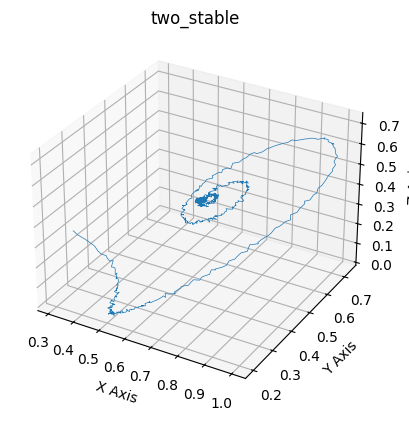

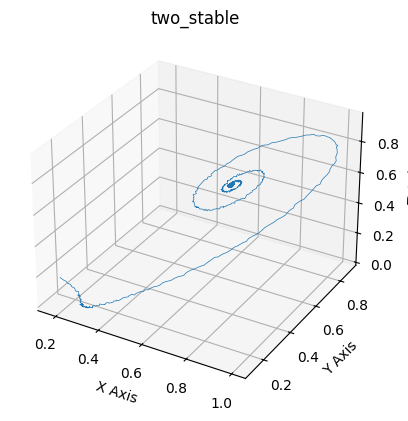

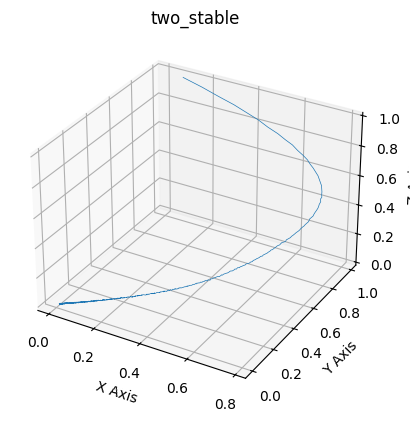

In [6]:
# Visualize the simulations model 1
visualize([simulations['two_stable'].perturbations_record['model3']['epoch1'][100], simulations['two_stable'].perturbations_record['model3']['epoch2'][100], simulations['curve'].perturbations_record['model3']['epoch3'][100]], "two_stable")

### We now want to compare the dissimilarity matrices for the 3 networks

In [ ]:
# For each attractor, pattern compute the 6 DSA between the 3 models
vectors_dsa = {pattern : {'vector1':None, 'vector2':None} for pattern in simulations}
for pattern in simulations:
    dsa1vs2_epoch1 = DSA.DSA(simulations[pattern].perturbations_record['model1']['epoch1'], simulations[pattern].perturbations_record['model2']['epoch1'],n_delays=config['dsa']['n_delays'],rank=config['dsa']['rank'],delay_interval=config['dsa']['delay_interval'],verbose=True,iters=1000,lr=1e-2)
    dsa2vs3_epoch1 = DSA.DSA(simulations[pattern].perturbations_record['model2']['epoch1'], simulations[pattern].perturbations_record['model3']['epoch1'],n_delays=config['dsa']['n_delays'],rank=config['dsa']['rank'],delay_interval=config['dsa']['delay_interval'],verbose=True,iters=1000,lr=1e-2)
    dsa1vs2_epoch2 = DSA.DSA(simulations[pattern].perturbations_record['model1']['epoch2'], simulations[pattern].perturbations_record['model2']['epoch2'],n_delays=config['dsa']['n_delays'],rank=config['dsa']['rank'],delay_interval=config['dsa']['delay_interval'],verbose=True,iters=1000,lr=1e-2)
    dsa2vs3_epoch2 = DSA.DSA(simulations[pattern].perturbations_record['model2']['epoch2'], simulations[pattern].perturbations_record['model3']['epoch2'], n_delays=config['dsa']['n_delays'],rank=config['dsa']['rank'],delay_interval=config['dsa']['delay_interval'],verbose=True,iters=1000,lr=1e-2)
    dsa1vs2_epoch3 = DSA.DSA(simulations[pattern].perturbations_record['model1']['epoch3'], simulations[pattern].perturbations_record['model2']['epoch3'],n_delays=config['dsa']['n_delays'],rank=config['dsa']['rank'],delay_interval=config['dsa']['delay_interval'],verbose=True,iters=1000,lr=1e-2)
    dsa2vs3_epoch3 = DSA.DSA(simulations[pattern].perturbations_record['model2']['epoch3'], simulations[pattern].perturbations_record['model3']['epoch3'], n_delays=config['dsa']['n_delays'],rank=config['dsa']['rank'],delay_interval=config['dsa']['delay_interval'],verbose=True,iters=1000,lr=1e-2)
    vector_1vs2 = np.array([dsa1vs2_epoch1.fit_score(), dsa1vs2_epoch2.fit_score(), dsa1vs2_epoch3.fit_score()])
    vector_2vs3 = np.array([dsa2vs3_epoch1.fit_score(), dsa2vs3_epoch2.fit_score(), dsa2vs3_epoch3.fit_score()])
    vectors_dsa[pattern]['vector1'] = vector_1vs2
    vectors_dsa[pattern]['vector2'] = vector_2vs3

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAV

In [ ]:
# For each attractor, pattern compute the 6 DSA between the 3 models
vectors_pa = {pattern : {'vector1':None, 'vector2':None} for pattern in simulations}
procrustes_measure = similarity.make("measure.sim_metric.cka-angular-score")
for pattern in simulations:
    pa1vs2_epoch1 = procrustes_measure(simulations[pattern].perturbations_record['model1']['epoch1'], simulations[pattern].perturbations_record['model2']['epoch1'])
    pa2vs3_epoch1 = procrustes_measure(simulations[pattern].perturbations_record['model2']['epoch1'], simulations[pattern].perturbations_record['model3']['epoch1'])
    pa1vs2_epoch2 = procrustes_measure(simulations[pattern].perturbations_record['model1']['epoch2'], simulations[pattern].perturbations_record['model2']['epoch2'])
    pa2vs3_epoch2 = procrustes_measure(simulations[pattern].perturbations_record['model2']['epoch2'], simulations[pattern].perturbations_record['model3']['epoch2'])
    pa1vs2_epoch3 = procrustes_measure(simulations[pattern].perturbations_record['model1']['epoch3'], simulations[pattern].perturbations_record['model2']['epoch3'])
    pa2vs3_epoch3 = procrustes_measure(simulations[pattern].perturbations_record['model2']['epoch3'], simulations[pattern].perturbations_record['model3']['epoch3'])
    vector_1vs2 = 1-np.array([pa1vs2_epoch1, pa1vs2_epoch2, pa1vs2_epoch3])
    vector_2vs3 = 1-np.array([pa2vs3_epoch1, pa2vs3_epoch2, pa2vs3_epoch3])
    vectors_pa[pattern]['vector1'] = vector_1vs2
    vectors_pa[pattern]['vector2'] = vector_2vs3

arccos score: 0.9998123525922509 0.01937283028544921 0.00018764740774912525
arccos score: 0.937401321929292 0.35570466313393645 0.06259867807070796
arccos score: 0.9999532581103483 0.009668738675782135 4.674188965170245e-05
arccos score: 0.9898849638270826 0.14235262305348884 0.010115036172917424
arccos score: 0.9999882883788882 0.004839761145390278 1.1711621111798465e-05
arccos score: 0.999987851980414 0.004929106243905535 1.2148019586044612e-05
arccos score: 0.999207970895897 0.039802856125519585 0.0007920291041030314
arccos score: 0.888347512861671 0.47706262500701874 0.11165248713832898
arccos score: 0.9998022207810829 0.019888978792160096 0.00019777921891706018
arccos score: 0.9721076511897114 0.23674030426483136 0.02789234881028857
arccos score: 0.9999507201355868 0.009927766029608454 4.927986441316534e-05
arccos score: 0.9999406348198723 0.010896400094323926 5.936518012772396e-05
arccos score: 0.9990914774054415 0.04263004097538715 0.0009085225945585362
arccos score: 0.489002073

### Visualization for each of the 4 tested patterns

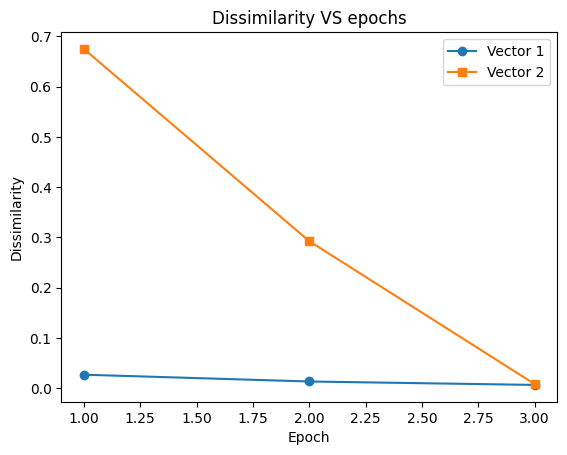

In [ ]:
# Indices for each component
components = np.array([1, 2, 3])

# Create the plot
plt.figure()
plt.plot(components, vectors_pa['two_stable']['vector1'], '-o', label='Vector 1')  # '-o' creates a line plot with circle markers
plt.plot(components, vectors_pa['two_stable']['vector2'], '-s', label='Vector 2')  # '-s' creates a line plot with square markers

# Adding title and labels
plt.title('Dissimilarity VS epochs')
plt.xlabel('Epoch')
plt.ylabel('Dissimilarity')

# Adding a legend
plt.legend()

# Display the plot
plt.savefig('data/dissimilarity_pa.png')
plt.show()


In [ ]:
vectors_dsa

{'staight_line': {'vector1': array([0.18121849, 0.18516965, 0.18008126]),
  'vector2': array([0.70014954, 0.68705851, 0.18280667])},
 'curve': {'vector1': array([0.1537677 , 0.14721461, 0.13637638]),
  'vector2': array([0.41602701, 0.37484151, 0.18481417])},
 'two_stable': {'vector1': array([0.13084744, 0.1168126 , 0.10738798]),
  'vector2': array([0.40484831, 0.35447329, 0.12192149])},
 'two_unstable': {'vector1': array([0.00997103, 0.00352105, 0.00872101]),
  'vector2': array([0.01894283, 0.01381942, 0.00084573])}}

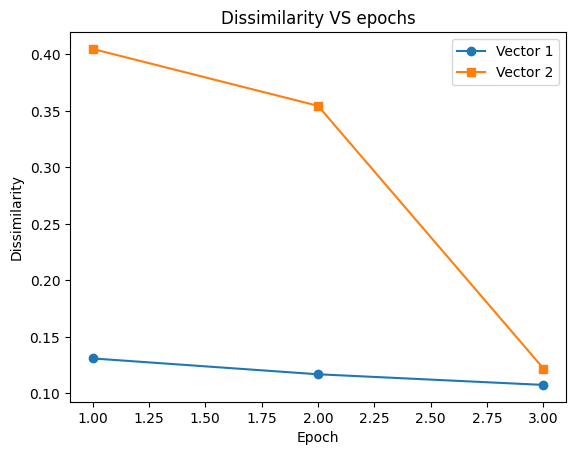

In [ ]:
# Indices for each component
components = np.array([1, 2, 3])

# Create the plot
plt.figure()
plt.plot(components, vectors_dsa['two_stable']['vector1'], '-o', label='Vector 1')  # '-o' creates a line plot with circle markers
plt.plot(components, vectors_dsa['two_stable']['vector2'], '-s', label='Vector 2')  # '-s' creates a line plot with square markers

# Adding title and labels
plt.title('Dissimilarity VS epochs')
plt.xlabel('Epoch')
plt.ylabel('Dissimilarity')

# Adding a legend
plt.legend()

# Display the plot
plt.savefig('data/dissimilarity_pa.png')
plt.show()

In [ ]:
vectors_dsa['two_stable']

{'vector1': array([0.13084744, 0.1168126 , 0.10738798]),
 'vector2': array([0.40484831, 0.35447329, 0.12192149])}

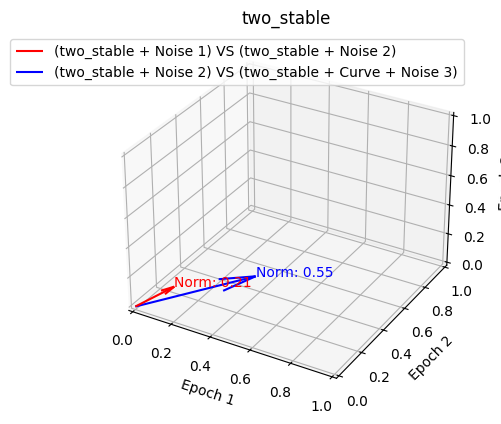

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Function to plot vectors in 3D
def plot_vectors(vector1, vector2, title, xlabel='Epoch 1', ylabel='Epoch 2', zlabel='Epoch 3'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.quiver(0, 0, 0, vector1[0], vector1[1], vector1[2], color='r', label='({} + Noise 1) VS ({} + Noise 2)'.format(title,title))
    ax.quiver(0, 0, 0, vector2[0], vector2[1], vector2[2], color='b', label='({} + Noise 2) VS ({} + Curve + Noise 3)'.format(title, title))

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    ax.text(vector1[0], vector1[1], vector1[2], f'Norm: {norm1:.2f}', color='r')
    ax.text(vector2[0], vector2[1], vector2[2], f'Norm: {norm2:.2f}', color='b')

    plt.title(title)
    ax.legend()
    plt.show()


plot_vectors(vectors_dsa['two_stable']['vector1'], vectors_dsa['two_stable']['vector2'], title='two_stable')

## References

[1]: Mitchell Ostrow, Adam Eisen, Leo Kozachkov, Ila Fiete, "Beyond Geometry: Comparing the Temporal Structure of Computation in Neural Circuits with Dynamical Similarity Analysis", 	arXiv:2306.10168
 